In [1]:
#make imports

import os
import sys
import warnings
import pandas as pd
import numpy as np
import pickle
import re
import unicodedata
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from wordcloud import WordCloud
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt

In [2]:
#ignore warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
#import headphones metadata and reviews in pandas dataframe

with open('headphone_meta_df.pkl', 'rb') as f:
    meta_df = pickle.load(f)

with open('headphone_review_df.pkl', 'rb') as f:
    review_df = pickle.load(f)

In [4]:
#print the number of rows and columns in metadata and reviews

print("the dimensions of the review dataframe are: ", review_df.shape)
print("the dimensions of the metadata dataframe are: ", meta_df.shape)

the dimensions of the review dataframe are:  (735, 12)
the dimensions of the metadata dataframe are:  (27396, 19)


In [5]:
print(review_df.columns)
print(meta_df.columns)

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')
Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details'],
      dtype='object')


In [6]:
#descriptive stats of the product

print("The number of reviews are: ", review_df.shape[0])
print("The average rating score is: ", review_df['overall'].mean())
print("The number of unique products are: ", len(review_df['asin'].unique()))
print("The number of good ratings are: ", review_df[review_df['overall'] >= 3].shape[0])
print("The number of bad ratings are: ", review_df[review_df['overall'] < 3].shape[0])
print("The number of reviews corresponding to each rating are: ", review_df['overall'].value_counts())

The number of reviews are:  735
The average rating score is:  3.379591836734694
The number of unique products are:  494
The number of good ratings are:  517
The number of bad ratings are:  218
The number of reviews corresponding to each rating are:  overall
5.0    231
4.0    162
1.0    127
3.0    124
2.0     91
Name: count, dtype: int64


In [7]:
acronyms_dict = {
    'lol': 'laugh out loud',
    'btw': 'by the way',
    'b4': 'before',
    'rofl': 'rolling on the floor laughing',
}

def preprocess_text(text):

    #remove the html tags
    text = re.sub(r'<.*?>', '', text)
    
    #remove accented characters
    #source: "https://guangyuwu.wordpress.com/2017/09/27/normalizing-unicode/"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    #expand acronyms
    for acronym, replacement in acronyms_dict.items():
        text = text.replace(acronym, replacement)

    #remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #lemmatize the text
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

    #normalize the text
    text = text.lower()

    return text

In [8]:
#preprocess the review text and add as a new column in the review dataframe

review_df['processed_text'] = review_df['reviewText'].apply(preprocess_text)

In [9]:
print(review_df['processed_text'])

11677      i buy at least a couple pair of koss headphone...
12708      wow for the price it pimp slap half the can i ...
12815      lasted a little over a year was expecting more...
14041      amazing sound quality in such a portable desig...
14062      ive had these headphone for a couple month now...
                                 ...                        
6406100    these headphone are extremely flimsy so flimsy...
6412066    i need over ear phone since my office mate i s...
6481656    i purchased this to view tv without disturbing...
6627772    i had read the review on these before i bought...
6716841    i consider myself an audiophile perse i love m...
Name: processed_text, Length: 735, dtype: object


The top 20 most reviewed brands are:  ['Sony', 'Sennheiser', 'Bose', 'V-MODA', 'beyerdynamic', 'Koss', 'Audio-Technica', 'Beats', 'Bluedio', 'Panasonic', 'MEE audio', 'JVC', 'Creative', 'EldHus', 'BRAINWAVZ', 'SMS Audio', 'Symphonized', 'Avantree', 'Jaybird', 'JBL']
The top 20 least reviewed brands are:  ['Jarv', 'Rokit Boost', 'White Label', 'Pioneer', 'HiFiMAn Electronics', 'CAD Audio', 'iLuv', 'Motorheadphones', 'It is', 'Gedun', 'Adventure Time', 'Tascam', 'Griffin Technology', 'Sentry Industries Inc.', 'Noontec', 'DAEETO', 'Seotic', 'Just Mobile', 'Aecoke', 'Audeze']
The most positively reviewed product is:  Koss SportaPro Stereo Headphones




The count of ratings for the product  Koss SportaPro Stereo Headphones  over 5 consecutive years are: 
year
2017    1
Name: overall, dtype: int64
The count of ratings for the product  Sennheiser HD 600 Open Back Professional Headphone  over 5 consecutive years are: 
year
2015    2
2016    1
Name: overall, dtype: int64
The count of ratings f

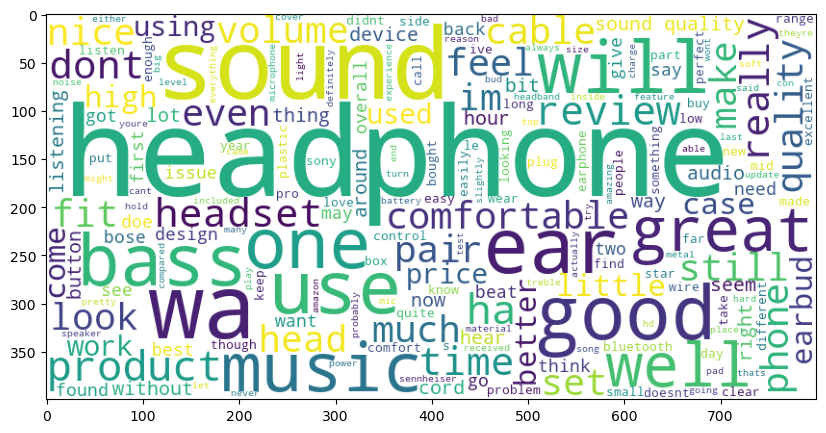

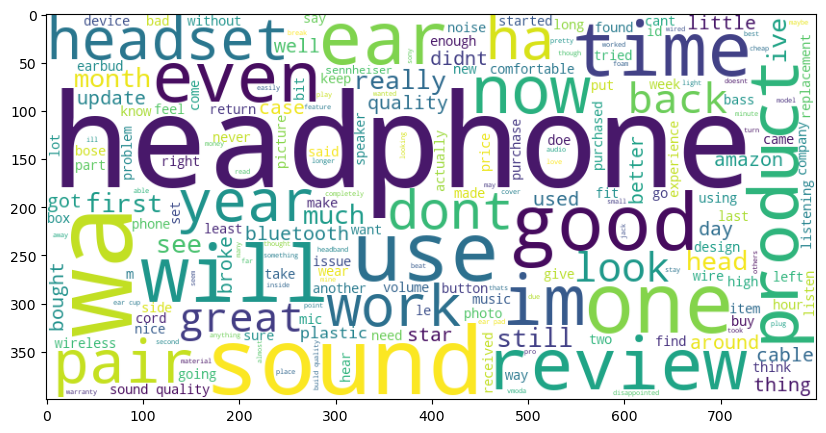

In [10]:
# (a) and (b)
asin_count = review_df['asin'].value_counts().to_dict()

brand_count = defaultdict(int)
for asin in asin_count:
    brand = meta_df[meta_df['asin'] == asin]['brand'].values[0]
    brand_count[brand] += asin_count[asin]

brand_count = dict(sorted(brand_count.items(), key=lambda x: x[1], reverse=True))

print("The top 20 most reviewed brands are: ", list(brand_count.keys())[:20])
print("The top 20 least reviewed brands are: ", list(brand_count.keys())[-20:])


# (c) 
most_positively_reviewed_asin = review_df.groupby('asin')['overall'].mean().idxmax()
most_positively_reviewed_product = meta_df[meta_df['asin'] == most_positively_reviewed_asin]['title'].values[0]
print("The most positively reviewed product is: ", most_positively_reviewed_product)
print("\n\n\n")

# (d)

#count of ratings of the top3 most positively reviewed products in different years with their titles
review_df['reviewTime'] = pd.to_datetime(review_df['reviewTime'])
review_df['year'] = review_df['reviewTime'].dt.year

top3_most_positively_reviewed_asins = review_df.groupby('asin')['overall'].mean().nlargest(3).index
for asin in top3_most_positively_reviewed_asins:
    product_title = meta_df[meta_df['asin'] == asin]['title'].values[0]
    print("The count of ratings for the product ", product_title, " over 5 consecutive years are: ")
    print(review_df[review_df['asin'] == asin].groupby('year')['overall'].count())
print("\n\n\n")

# (e)

good_reviews = review_df[review_df['overall'] >= 3]['processed_text'].str.cat(sep=' ')
bad_reviews = review_df[review_df['overall'] < 3]['processed_text'].str.cat(sep=' ')

good_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(good_reviews)
bad_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(bad_reviews)

#print wordcloud images

plt.figure(figsize=(10, 5))
plt.imshow(good_wordcloud)

plt.figure(figsize=(10, 5))
plt.imshow(bad_wordcloud)

The distribution of ratings vs the number of reviews is: 


<Axes: ylabel='count'>

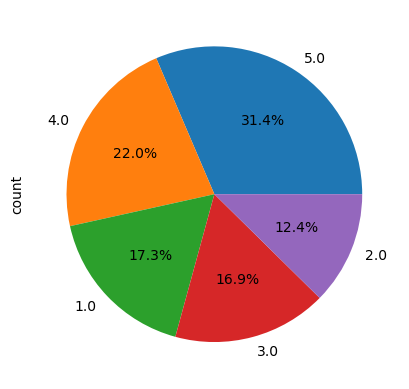

In [11]:
# (f)

rating_distribution = review_df['overall'].value_counts()
print("The distribution of ratings vs the number of reviews is: ")
rating_distribution.plot.pie(autopct='%1.1f%%')

In [12]:
# (g)
print("The year in which the most positively reviewed product got maximum reviews is: ", review_df[review_df['asin'] == most_positively_reviewed_asin]['year'].value_counts().idxmax())

# (h)
print("The year with the highest number of customers is: ", review_df['year'].value_counts().idxmax())

The year in which the most positively reviewed product got maximum reviews is:  2017
The year with the highest number of customers is:  2015


In [13]:
#q7 word2vec

EMBEDDING_DIM = 100
word2vec_model = KeyedVectors.load_word2vec_format('/Users/mo/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

def gen_embedding(text):
    words = text.split()
    all_embeds = np.zeros((len(words), EMBEDDING_DIM))

    for i, word in enumerate(words):
        try:
            all_embeds[i] = word2vec_model[word][:EMBEDDING_DIM]
        except KeyError:
            all_embeds[i] = np.zeros(EMBEDDING_DIM)

    return np.mean(all_embeds, axis=0)

review_df['embedding'] = review_df['processed_text'].apply(gen_embedding)

In [14]:
# make rating class column
# encode good as 1, average as 0, bad as -1

review_df['rating_class'] = review_df['overall'].apply(lambda x: 1 if x > 3 else (-1 if x < 3 else 0))
print(review_df['rating_class'])

11677      1
12708      1
12815      0
14041      1
14062      1
          ..
6406100    0
6412066   -1
6481656   -1
6627772    0
6716841    1
Name: rating_class, Length: 735, dtype: int64


In [15]:
# load data to a list

embed_data = (review_df['embedding'].to_list())
embed_labels = (review_df['rating_class'].to_list())

print(embed_data[0].shape)
print(embed_labels[0])
print(len(embed_data))

(100,)
1
735


In [16]:
# make train test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(embed_data, embed_labels, test_size=0.25, random_state=42)

In [17]:
#run 5 ml models on the aobve data and report precision, recall, f1

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("The classification report for ", model_name, " is: ")
    print(classification_report(y_test, y_pred))

The classification report for  Logistic Regression  is: 
              precision    recall  f1-score   support

          -1       1.00      0.10      0.18        50
           0       0.00      0.00      0.00        33
           1       0.56      1.00      0.72       101

    accuracy                           0.58       184
   macro avg       0.52      0.37      0.30       184
weighted avg       0.58      0.58      0.45       184

The classification report for  SVM  is: 
              precision    recall  f1-score   support

          -1       0.75      0.54      0.63        50
           0       0.00      0.00      0.00        33
           1       0.66      0.96      0.78       101

    accuracy                           0.67       184
   macro avg       0.47      0.50      0.47       184
weighted avg       0.56      0.67      0.60       184

The classification report for  Random Forest  is: 
              precision    recall  f1-score   support

          -1       0.52      0.52 

In [18]:
#find the total number of users
num_unique_users = review_df['reviewerID'].nunique()
print("The total number of users are: ", num_unique_users)

#find the total number of products
num_unique_prods = review_df['asin'].nunique()
print("The total number of products are: ", num_unique_prods)

The total number of users are:  705
The total number of products are:  494


In [19]:
# create a user-item rating matrix

user_item_mat = review_df.pivot_table(index='reviewerID', columns='asin', values='overall')
print(user_item_mat.shape)

(705, 494)


In [20]:
# normalize ratings

user_item_mat = user_item_mat.apply(lambda x: (x - np.min(x)) / ((np.max(x) - np.min(x)) + 0.00001), axis=1)

In [21]:
# make 5-fold train test split for users

from sklearn.model_selection import KFold

def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

kf = KFold(n_splits=5)

N_NEIGHBORS = [10, 20, 30, 40, 50]
mae_nn = []

for num_n in N_NEIGHBORS:
    mae_values = []
    print("The number of neighbors is: ", num_n)

    for train_index, test_index in kf.split(user_item_mat):
        train_users = user_item_mat.index[train_index]
        test_users = user_item_mat.index[test_index]

        user_item_mat_train = user_item_mat.loc[train_users]
        user_item_mat_train = user_item_mat_train.fillna(0)

        top_n_sim = dict()
        for user in train_users:
            top_n_sim[user] = user_item_mat_train.apply(lambda x: cosine_sim(user_item_mat_train.loc[user], x), axis=1).nlargest(num_n).index

        # Use the nearest neighbours to predict the missing values in the user-item rating matrix
        for user in train_users:
            for product in user_item_mat.columns:
                if (user_item_mat.loc[user, product] == 0):
                    user_item_mat.loc[user, product] = np.mean(user_item_mat.loc[top_n_sim[user], product])

        # create a user-item rating matrix from the validation set
        user_item_mat_test = user_item_mat.loc[test_users]
        user_item_mat_test = user_item_mat_test.fillna(0)

        # compare the actual values from the validation set to the predicted values in the training set, and calculate the Mean Absolute Error.
        mae_tmp = []

        for test_user in test_users:
            for train_user in train_users:
                mae = 0
                for product in user_item_mat_test.columns:
                    mae += abs(user_item_mat_test.loc[test_user, product] - user_item_mat_train.loc[train_user, product])
                mae /= user_item_mat_test.shape[1]
                mae_tmp.append(mae)

        mae = sum(mae_tmp) / len(mae_tmp)+1
        print("The mean absolute error is: ", mae)
        mae_values.append(mae)

    if len(mae_values) != 0:  # Avoid division by zero
        mae_nn.append(float(sum(mae_values)) / len(mae_values))
        print("The mean absolute error is: ", mae_nn[-1])
    else:
        print("No ratings to predict")

The number of neighbors is:  10
The mean absolute error is:  1.0001256198286155
The mean absolute error is:  1.0001148523744847
The mean absolute error is:  1.0001148523744847
The mean absolute error is:  1.0000933176456794
The mean absolute error is:  1.0001256199632076
The mean absolute error is:  1.0001148524372945
The number of neighbors is:  20
The mean absolute error is:  1.0001256198286155
The mean absolute error is:  1.0001148523744847
The mean absolute error is:  1.0001148523744847
The mean absolute error is:  1.0000933176456794
The mean absolute error is:  1.0001256199632076
The mean absolute error is:  1.0001148524372945
The number of neighbors is:  30
The mean absolute error is:  1.0001256198286155
The mean absolute error is:  1.0001148523744847
The mean absolute error is:  1.0001148523744847
The mean absolute error is:  1.0000933176456794
The mean absolute error is:  1.0001256199632076
The mean absolute error is:  1.0001148524372945
The number of neighbors is:  40
The mean

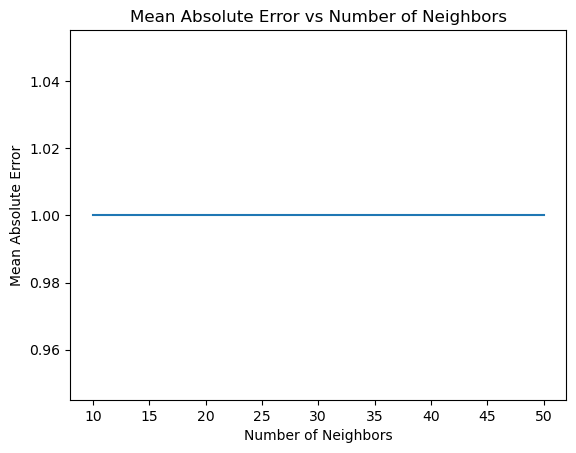

In [22]:
#plot the mean absolute error vs the number of neighbors

plt.plot(N_NEIGHBORS, mae_nn)
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs Number of Neighbors')
plt.show()